In [1]:
# !wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz

--2025-04-12 14:37:57--  https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1360814128 (1.3G) [application/x-gzip]
Saving to: ‘NLMCXR_png.tgz’

NLMCXR_png.tgz      100%[===================>]   1.27G  8.43MB/s    in 2m 34s  

2025-04-12 14:40:32 (8.41 MB/s) - ‘NLMCXR_png.tgz’ saved [1360814128/1360814128]



In [3]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [4]:
import kaggle
import os

# Define your preferred download path
preferred_path = "/scratch/joshi.tanm/CSYE-7374/final-project/data"

# Ensure the directory exists
os.makedirs(preferred_path, exist_ok=True)

# Download and unzip the dataset
kaggle.api.dataset_download_files(
    'raddar/chest-xrays-indiana-university',
    path=preferred_path,
    unzip=True
)

print("Dataset downloaded and extracted to:", preferred_path)

Dataset URL: https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university
Dataset downloaded and extracted to: /scratch/joshi.tanm/CSYE-7374/final-project/data


## Data Visualization

In [1]:
import pandas as pd
projections = pd.read_csv("data/indiana_projections.csv")
reports = pd.read_csv("data/indiana_reports.csv")

In [2]:
projections.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [3]:
reports.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [4]:
dataset = pd.merge(
    projections,
    reports,
    on='uid',
    suffixes=('_image', '_report')
)

In [5]:
dataset.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."


In [6]:
dataset.shape

(7466, 10)

In [7]:
!pwd

/scratch/joshi.tanm/CSYE-7374/final-project


In [9]:
dataset.to_csv("dataset.csv")

##  Image with captions

In [11]:
!pip install pillow torchvision

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

In [14]:
def read_img_pil(img_path, target_size = (224,224)):
    """
    Read and preprocess an image using PIL/Pillow.
    
    Args:
        image_path: Path to the image file
        target_size: Size to resize the image to (height, width)
    
    Returns:
        Preprocessed image as a tensor ready for deep learning models
    """
    try:
        # open the image
        image  = Image.open(img_path)

        # Convert to grayscale if it's not already
        if image.mode != 'L':
            image = image.convert('L')

        # Define preprocessing steps
        preprocess = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),  # Scales to [0,1]
            transforms.Normalize(mean=[0.5], std=[0.5]),  # Scale to [-1,1]
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
        ])

        # Apply preprocessing
        tensor_image = preprocess(image)
        
        return tensor_image

    except Exception as e:
        print(f"Error reading image: {e}")
        return None
        
    

In [22]:
img_path = f"data/images/images_normalized/{dataset['filename'][0]}"
tensor_image = read_img_pil(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


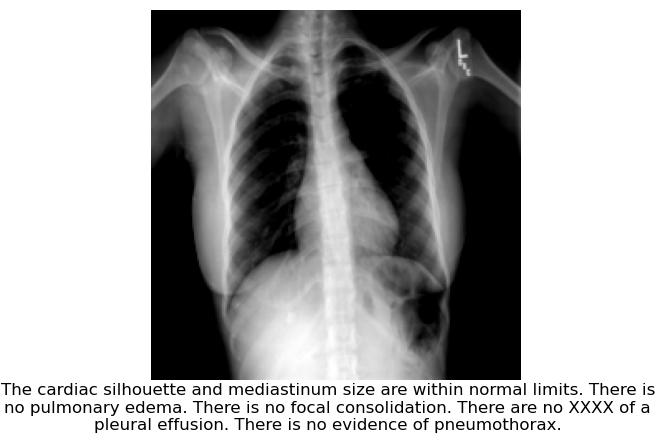

In [28]:
from matplotlib import pyplot as plt
np_image = tensor_image.permute(1, 2, 0).numpy()
    
# Display
plt.imshow(np_image)
plt.figtext(0.5, 0.01, f"{dataset['findings'][0]}", ha="center", fontsize=12, wrap=True)
# 0.5: x-coordinate (horizontal center)
# 0.01: y-coordinate (near bottom of the figure)
# ha="center": horizontal alignment
# fontsize: font size
# wrap=True: wraps long text


plt.axis('off')
plt.show()

## EDA

In [1]:
import pandas as pd
dataset = pd.read_csv("dataset.csv")


In [2]:
dataset.isnull().sum()

Unnamed: 0       0
uid              0
filename         0
projection       0
MeSH             0
Problems         0
image            0
indication     159
comparison    2260
findings       997
impression      52
dtype: int64

In [3]:
dataset.dropna(subset=['findings'],inplace=True)

In [4]:
dataset.isnull().sum()

Unnamed: 0       0
uid              0
filename         0
projection       0
MeSH             0
Problems         0
image            0
indication     103
comparison    1625
findings         0
impression      12
dtype: int64

In [5]:
dataset.head()

,Unnamed: 0,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
6,6,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...


In [6]:
dataset['impression']

0                                    Normal chest x-XXXX.
1                                    Normal chest x-XXXX.
2                            No acute pulmonary findings.
3                            No acute pulmonary findings.
6       1. Bullous emphysema and interstitial fibrosis...
                              ...                        
7457    1. Interval resolution of bibasilar airspace d...
7458    Clear lungs. No acute cardiopulmonary abnormal...
7459    Clear lungs. No acute cardiopulmonary abnormal...
7460        No acute findings, no evidence for active TB.
7461        No acute findings, no evidence for active TB.
Name: impression, Length: 6469, dtype: object

## Data Preparation

In [22]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
dataset['final_img_path'] = [f"data/images/images_normalized/{x}" for x in dataset['filename']]

In [10]:
dataset.dropna(subset = ['impression'],inplace=True)

In [12]:
dataset.isnull().sum()

Unnamed: 0           0
uid                  0
filename             0
projection           0
MeSH                 0
Problems             0
image                0
indication         103
comparison        1621
findings             0
impression           0
final_img_path       0
dtype: int64

In [13]:
dataset.head()

,Unnamed: 0,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,final_img_path
0,0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,data/images/images_normalized/1_IM-0001-4001.d...
1,1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,data/images/images_normalized/1_IM-0001-3001.d...
2,2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,data/images/images_normalized/2_IM-0652-1001.d...
3,3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,data/images/images_normalized/2_IM-0652-2001.d...
6,6,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,data/images/images_normalized/4_IM-2050-1001.d...


In [15]:
dataset['captions'] = [f"{row['projection']} chest x-ray showing {row['impression']}" for _,row in dataset.iterrows()]

In [16]:
dataset.head()

,Unnamed: 0,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,final_img_path,captions
0,0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,data/images/images_normalized/1_IM-0001-4001.d...,Frontal chest x-ray showing Normal chest x-XXXX.
1,1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,data/images/images_normalized/1_IM-0001-3001.d...,Lateral chest x-ray showing Normal chest x-XXXX.
2,2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,data/images/images_normalized/2_IM-0652-1001.d...,Frontal chest x-ray showing No acute pulmonary...
3,3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,data/images/images_normalized/2_IM-0652-2001.d...,Lateral chest x-ray showing No acute pulmonary...
6,6,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,data/images/images_normalized/4_IM-2050-1001.d...,Frontal chest x-ray showing 1. Bullous emphyse...


In [17]:
dataset.captions

0        Frontal chest x-ray showing Normal chest x-XXXX.
1        Lateral chest x-ray showing Normal chest x-XXXX.
2       Frontal chest x-ray showing No acute pulmonary...
3       Lateral chest x-ray showing No acute pulmonary...
6       Frontal chest x-ray showing 1. Bullous emphyse...
                              ...                        
7457    Lateral chest x-ray showing 1. Interval resolu...
7458    Frontal chest x-ray showing Clear lungs. No ac...
7459    Lateral chest x-ray showing Clear lungs. No ac...
7460    Frontal chest x-ray showing No acute findings,...
7461    Lateral chest x-ray showing No acute findings,...
Name: captions, Length: 6457, dtype: object

In [19]:
dataset.final_img_path

0       data/images/images_normalized/1_IM-0001-4001.d...
1       data/images/images_normalized/1_IM-0001-3001.d...
2       data/images/images_normalized/2_IM-0652-1001.d...
3       data/images/images_normalized/2_IM-0652-2001.d...
6       data/images/images_normalized/4_IM-2050-1001.d...
                              ...                        
7457    data/images/images_normalized/3995_IM-2046-200...
7458    data/images/images_normalized/3996_IM-2047-100...
7459    data/images/images_normalized/3996_IM-2047-300...
7460    data/images/images_normalized/3997_IM-2048-100...
7461    data/images/images_normalized/3997_IM-2048-100...
Name: final_img_path, Length: 6457, dtype: object

In [20]:
final_dataset = dataset[['final_img_path','captions']]

In [21]:
final_dataset.to_csv("final_dataset.csv")

In [25]:
def read_img_pil(img_path, target_size = (224,224)):
    """
    Read and preprocess an image using PIL/Pillow.
    
    Args:
        image_path: Path to the image file
        target_size: Size to resize the image to (height, width)
    
    Returns:
        Preprocessed image as a tensor ready for deep learning models
    """
    try:
        # open the image
        image  = Image.open(img_path)

        # Convert to grayscale if it's not already
        if image.mode != 'L':
            image = image.convert('L')

        # Define preprocessing steps
        preprocess = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),  # Scales to [0,1]
            transforms.Normalize(mean=[0.5], std=[0.5]),  # Scale to [-1,1]
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
        ])

        # Apply preprocessing
        tensor_image = preprocess(image)
        
        return tensor_image

    except Exception as e:
        print(f"Error reading image: {e}")
        return None

def display_tensor_to_image(tensor_image, caption):
    """
    Reads image in the form of tensors to display a grayscale image along with its caption

    Args:
        img_tensor: Tensor representation of an image
        caption: Caption of that image

    Returns:
        None: Plots an image along with caption

    """
    
    np_image = tensor_image.permute(1, 2, 0).numpy()
    
    # Display
    plt.imshow(np_image)
    plt.figtext(0.5, 0.01, f"{caption}", ha="center", fontsize=12, wrap=True)
    # 0.5: x-coordinate (horizontal center)
    # 0.01: y-coordinate (near bottom of the figure)
    # ha="center": horizontal alignment
    # fontsize: font size
    # wrap=True: wraps long text
    
    
    plt.axis('off')
    plt.show()

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


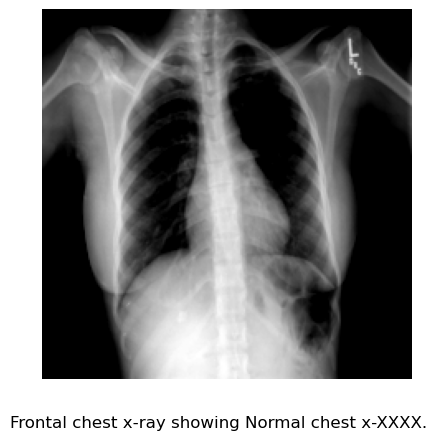

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


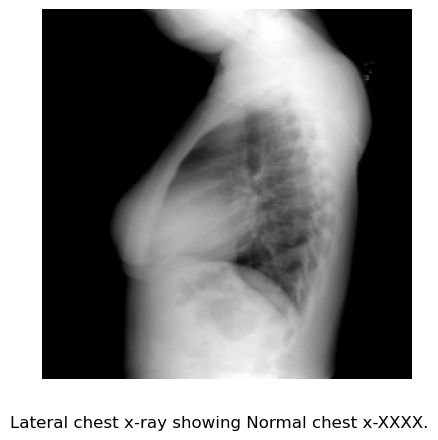

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


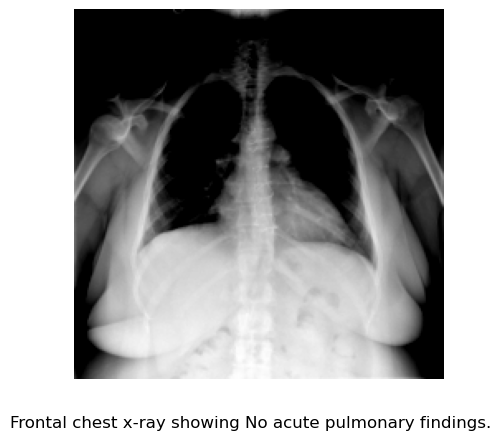

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


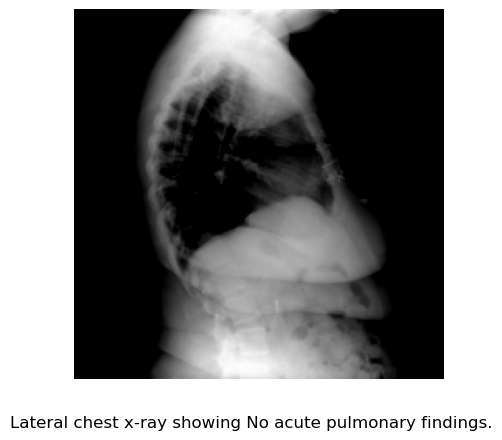

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


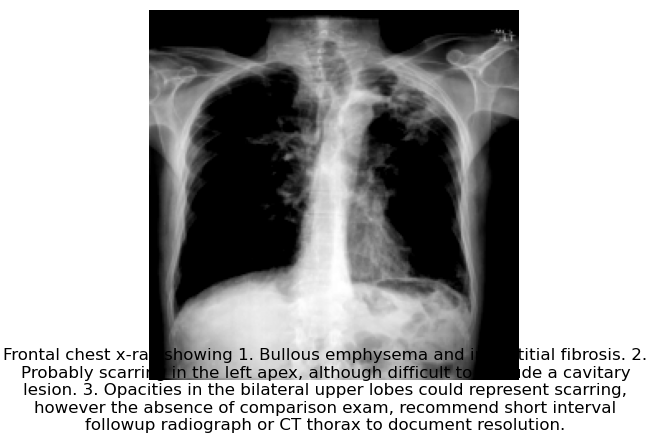

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


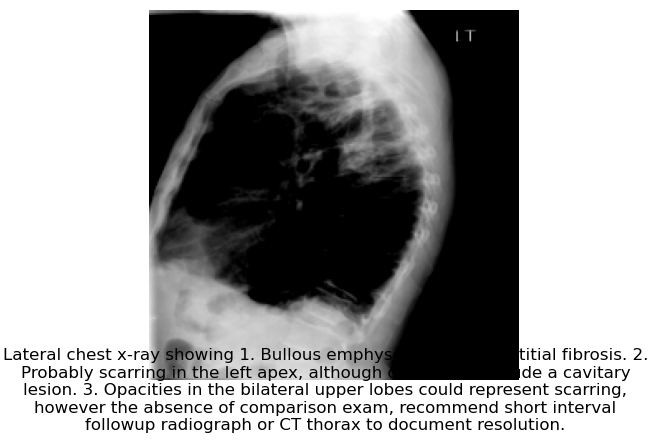

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


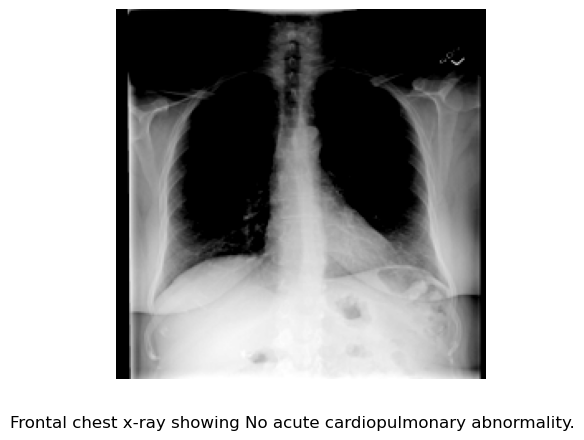

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


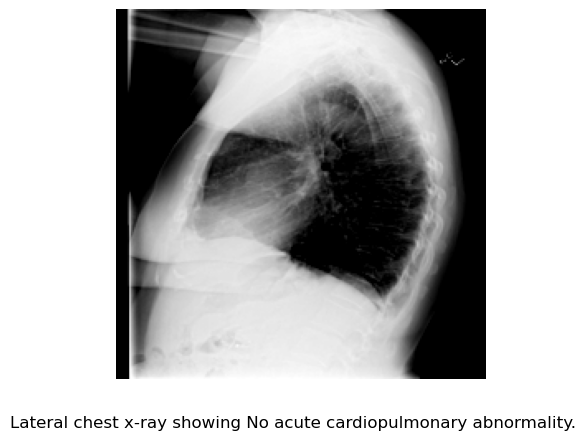

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


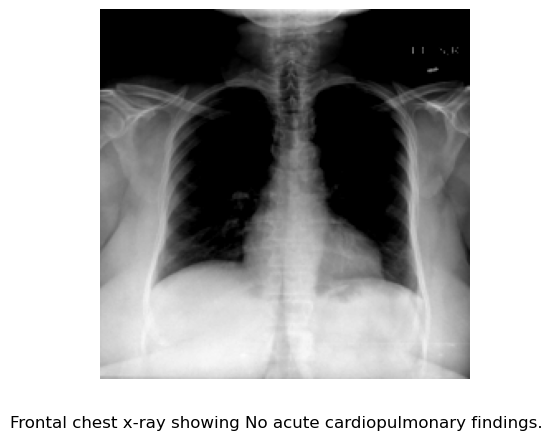

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


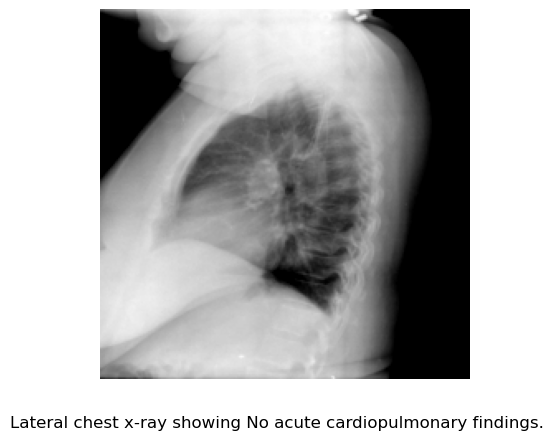

In [26]:
for i in range(10):
    img_path = final_dataset['final_img_path'].iloc[i]
    caption = final_dataset['captions'].iloc[i]
    display_tensor_to_image(read_img_pil(img_path), caption)